# Workshop 1: excersices for practice

This workshops 1 problems are not assessed and are intended for practicing the the concepts introduced in the 1st ML lecture, the and the notebooks `data-science-tools.ipynb` and `lecture2.ipynb`. 

It is recommended that you go thorugh those notebooks 1st and try to understand each line before jumping into the excersises.

*Responsible:* Guillermo Hamity (<daml-ml@pm.me>)

## Wine quality dataset

The [wine quality dataset](https://archive.ics.uci.edu/ml/datasets/wine%20quality) will be analysed

### Dataset information
Two datasets were created, using red and white wine samples.
The inputs include objective tests (e.g. PH values) and the output is based on sensory data
(median of at least 3 evaluations made by wine experts). Each expert graded the wine quality 
between 0 (very bad) and 10 (very excellent). 
  
1. Number of Instances: red wine - 1599; white wine - 4898. 

2. Number of Attributes: 11 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of
   feature selection.

3. Attribute information:

   For more information, read [Cortez et al., 2009].

   Input variables (based on physicochemical tests):
   1. fixed acidity
   
   2. volatile acidity
   
   3. citric acid
   
   4. residual sugar
   
   5. chlorides
   
   6. free sulfur dioxide
   
   7. total sulfur dioxide
   
   8. density
   
   9. pH
   
   10. sulphates
   
   11. alcohol
   
   12. type (R=red, W=white)
   
   Output variable (based on sensory data): 
   12 - quality (score between 0 and 10)

### Purpose:

We will design a model which predicts the quality of **RED** wine based on the input features. In order to achive this we will perform some initial investigations, preperation, and visiualisation of the data. We will then train decition trees to distinguish good vs bad  **red** wines, and check the validity of our model on a testing dataset.

### Working through the problems
* Try and calculate the answers provided. 
* Keep code understandable and reproducible, i.e. the notebook can be **restarted** and **re-run**. You will need to do this when work is marked, so better to start practicing.
* If you are unsure on how to proceed please reference the two companion notebooks for relevant examples, or **ask one of the TAs**

### Notes on solution
* This CP exercise sheet is divided into three sections, corresponding to parts of the lecture. The problems will **not** be marked.
  - Data science tools 
  - Visualisation 
  - Decision tree classification + ensemble methods
* Exercises 1-5 can be solved with one line of code while still being legible. _(That's not a weird flex, nor required, just letting you know that if you find yourself with a 20-line long solution, it can probably be done in a simpler way.)_
* The following `pandas.DataFrame` functions may be useful: `head`, `describe`, `loc`, `query`, `unique`, `value_counts`, `sort_values`, `group_by`, `apply`, `transform`.

In [1]:
# Standard import(s)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

In [2]:
# Load wine dataset
obs = pd.read_csv('wine_quality.csv')

In [3]:
# Show available properties of the dataset
obs.keys()

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'type'],
      dtype='object')

In [4]:
# Show dataset description
obs.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,W
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,W
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,W
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,W
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,W


In [5]:
# Drop duplicate measurements -- makes sense in this case, since measurements 
# with identical rows would imply identical wines (at least in composition),
# which would be double counted in the dataset
obs = obs.drop_duplicates()

---
## Data science tools 

This section covers exercises on data handling using pandas.DataFrames.
###### 1. How many observations have been collected and how many features are listed per observation? 

In [6]:
obs.shape

(5320, 13)

###### 2. How may wines are of each type, Red  and White?

In [7]:
obs["type"].value_counts()

R    3961
W    1359
Name: type, dtype: int64

###### 3. What are the minimum and maximum wine qualities in the dataset ? 


In [8]:
obs.describe()["quality"][["min","max"]]

min    3.0
max    9.0
Name: quality, dtype: float64

###### 4. Which type of wine (red or white) has the higher score on average ? 
_Hints:_
1. Group the data by type, ie, white and red wine
2. Get the mean of the quality for each type


In [9]:
obs.groupby("type")["quality"].mean()

type
R    5.854835
W    5.623252
Name: quality, dtype: float64

#### 5. How many measurements are there for each quality value per wine type?
Hits:
- group the data by type and quality
- count the values in each group



In [10]:
obs.groupby(["type","quality"])["fixed_acidity"].count()

type  quality
R     3            20
      4           153
      5          1175
      6          1788
      7           689
      8           131
      9             5
W     3            10
      4            53
      5           577
      6           535
      7           167
      8            17
Name: fixed_acidity, dtype: int64

#### 6. Data preperation

From the investigation above we can see varying statistics between the red and white wines. Lets prepare the data in such a way that we define good and bad quality wines based on the median value of each wine type.

Make two datasets named `white` and `red` by doing the following

1. goup the data into Red and White wine
2. find the median values of quality for red and white wines seperately
3. create a new quality variable `good_qual` which is 0 for bad (less than the median) and 1 for good (more than or equal to the median)
4. drop columns `quality` and `type` from the datasets as they are no longer needed. Use the `drop` method


In [11]:
#group by type
groups = obs.groupby("type")

#One way to do it:

red = groups.get_group("R").copy()
white = groups.get_group("W").copy()
#note: using copy() of dataset suppresses warnings on acting on slices of the data

red["good_qual"] = (red["quality"] >= red["quality"].median()).astype(int)
white["good_qual"] = (white["quality"] >= white["quality"].median()).astype(int)

red.drop(columns=["quality","type"],inplace=True)
white.drop(columns=["quality","type"],inplace=True)

# More efficient way to do it:
#use transform to apply the boolean expression per group, set as int, and decorate the new variable into dataframe
#obs["good_qual"] = groups["quality"].transform(lambda x: (x >=x.median()).astype(int))
#define the new dataframes
#red = groups.get_group("R")
#white = groups.get_group("W")

---
## From here on we will be focusing on the **red** wine dataset

--------------------------------------------------------
###### 7.  Use the describe method to show statistics per good/bad wine in the red wine dataset for alcohol and sulphates

In [12]:
red.groupby("good_qual").describe()[["alcohol","sulphates"]]

alcohol                                                   sulphates  \
            count       mean       std  min   25%   50%   75%   max     count   
good_qual                                                                       
0          1348.0   9.909172  0.895594  8.0   9.2   9.7  10.5  13.6    1348.0   
1          2613.0  10.940254  1.212499  8.5  10.0  10.9  12.0  14.2    2613.0   

                                                             
               mean       std   min   25%   50%   75%   max  
good_qual                                                    
0          0.481825  0.100946  0.25  0.41  0.47  0.53  0.88  
1          0.494749  0.119275  0.22  0.41  0.48  0.56  1.08

---
## Visualisation 
---
This section covers 2 exercises on visualisation using `matplotlib.pyplot`. 

###### 8 Make a correlation plot of all the features in the red wine dataset
- Use the porvided colormap
- Use the sns.heatmap function as shown in the lecture
- set the tick labels to represent the feature names


In [13]:
# Use the following courmap in as the cmap parameter of sns.heatmap:
colormap = sns.diverging_palette(220, 10, as_cmap=True)

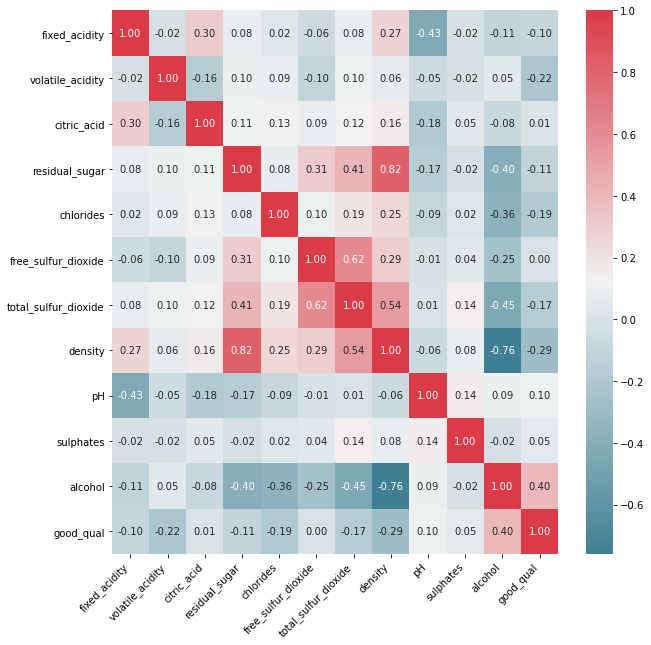

In [14]:
#Get the correlation matrix
corr_matrix = red.corr()
# Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr_matrix, cmap=colormap, annot=True, fmt=".2f")
ax.set_xticklabels(
    red.columns,
    rotation=45,
    horizontalalignment='right'
);
ax.set_yticklabels(red.columns);
plt.show()

##### 9 Pick the top five most correlated features to chlorides and make a pairplot split by good_qual

- Do not include "good_qual" in the calculation of most correlated
- Negative and positive correlations both show strong correlation (or anti correlation). Use the ablsolute value to pick the most correlated features

In [15]:
corr_abs = corr_matrix.abs()
high_corr_chlorides = list(corr_abs["chlorides"].drop("good_qual").sort_values(ascending=False)[0:6].index)
print(high_corr_chlorides)

['chlorides', 'alcohol', 'density', 'total_sulfur_dioxide', 'citric_acid', 'free_sulfur_dioxide']


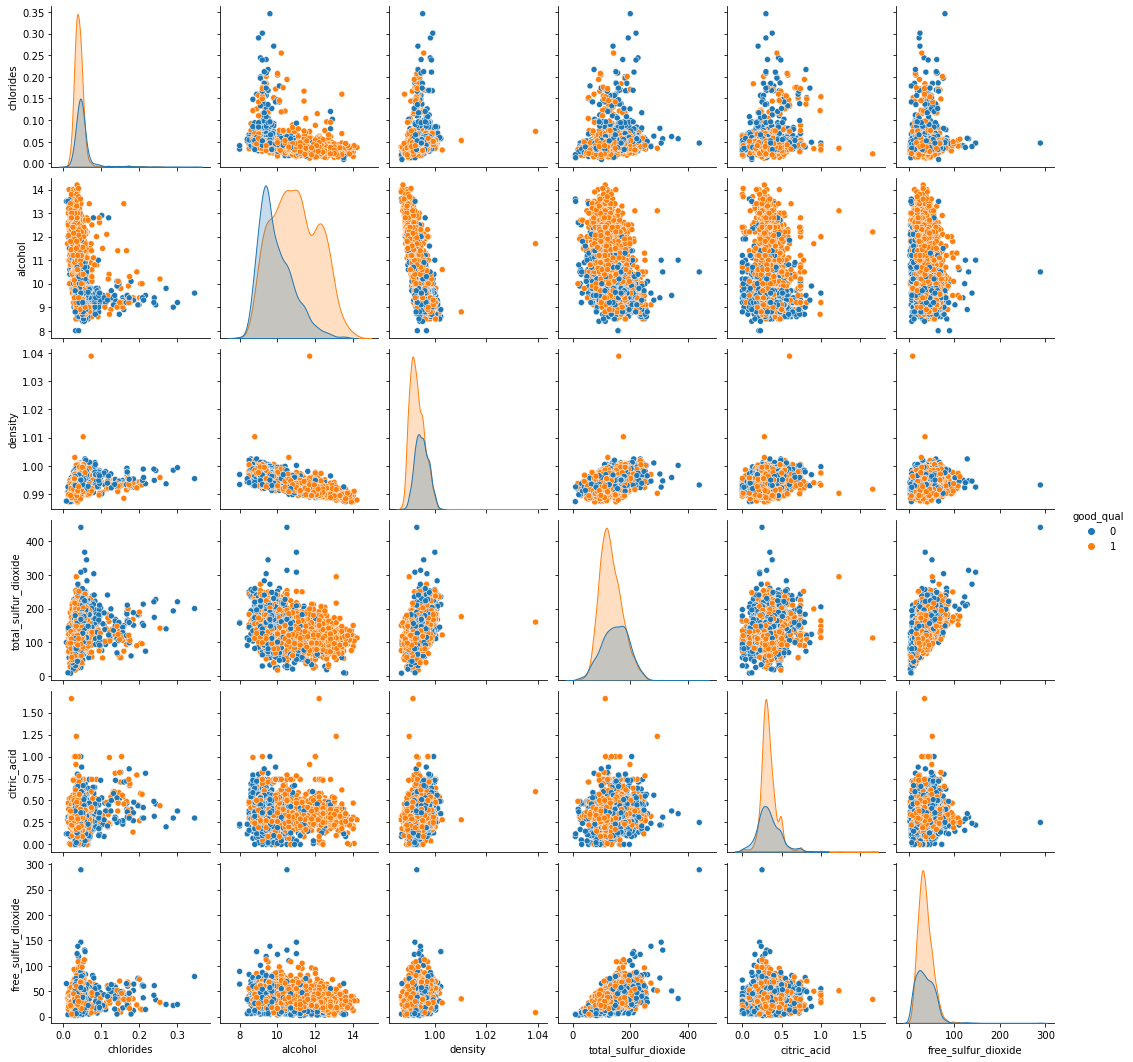

In [16]:
sns.pairplot(red[high_corr_chlorides+["good_qual"]], hue = 'good_qual',);

#### 8. Make a scatter plot of the two most correlated features.
Example solution:

- Find the two most correlated features (well you can read them from the plot above, but try find them yourself by)
  - Mask diagonal points in the |correlation| matrix
  - Unstack the dataframe into a pandas Series
  - sort the values in decending order, then pick the top value (or use idxmax)
- Make the scatter plot using the ax.scatter method.
  - Make the distributions legible, either by setting the opacity (alpha=...).
  - Label X axis, and Y axis including units.
  - Include a legend two wine types.
- Discuss the figure. Do you think using the both variables to distinguish wine quality is usefull?  



In [17]:
most_corr = corr_abs[corr_abs<1].unstack().sort_values(ascending=False).head(1)
print(most_corr)

residual_sugar  density    0.820498
dtype: float64


/home/guillermo/miniconda/envs/daml/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


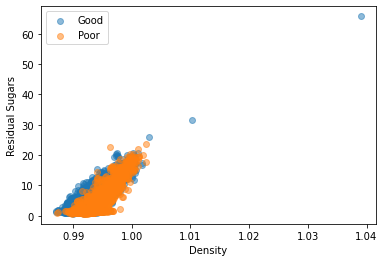

In [18]:
label = ["Poor","Good"]
feat1 = most_corr.index[0][1]
feat2 = most_corr.index[0][0]
# Create figure and axis objects.
fig, ax = plt.subplots()
for t in red['good_qual'].unique():
    mask = red['good_qual'] == t
    ax.scatter(red[feat1][mask], red[feat2][mask], label=label[t], alpha=0.5)
    pass
ax.set_xlabel('Density')
ax.set_ylabel('Residual Sugars')
ax.legend();
fig.show()

**A:** Highly correlated variables tend to not offer unique information and we can generally consider dropping **one** them to simplify our models.

#### 9. Prepare a smaller pandas.DataFrame for visualisation and classification 

In the next sections, on decision trees and ensemble methods, we will try to classify the wine quality --- based on a subset of the available features. We also introduce labels for Poor and Good wines for plotting purposes:


In [19]:
# define data and features
features = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
target   = ['good_qual']
wtype = ["Poor","Good"]


#### Therefore:

* Create a pandas.DataFrame, called dataset, which contains only the desired features and the target variable;
* Drop duplicates and NaN-values;
* Shuffle the dataframe;
* Create a pandas.DataFrame, called frames, containing the first 1000 observations of the dataset for each class
* Create a sample dataset by doing the concat of frames
* From sample panda dataframe convert into a numpy array for the inputs (called X) and target (called y);
* Flatten the converted y array; and
* Check their shapes to make sure they look alright.



In [20]:
# Combine features and target to create a smaller dataset
dataset = red[features + target]

# Drop duplicates and null values 
dataset = dataset.drop_duplicates().dropna()

# Shuffle
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Get first 50 observations 
frames = [dataset[dataset.good_qual == 0].head(1000), 
          dataset[dataset.good_qual == 1].head(1000)]

sample = pd.concat(frames)

# Convert pandas.DataFrame to numpy.array
X = sample[features].values
y = sample[target].values.flatten()

# Check shapes
X.shape, y.shape

((2000, 11), (2000,))

## Decision tree classification 
---
This section covers 3 exercises on the use and understanding of decision trees and ensemble methods.

#### 10. Fit a decision tree classifier and plot the decision

* Split dataset into training set and test set (x_train, x_test, y_train, y_test)
* Create a `sklearn.tree.DecisionTreeClassifier` and set the maximum tree depth to 4, use `entropy` as the quality criterion.
* Fit the decision tree classifier
* Predict the response for the test and training datasets
* Print the accuracy of test and training datasets
* Make the decision tree graph and save it in png
* Find the important feature in the decision tree (use feature_importances method in the decision tree). Why do you think this feature is of particular importance in distinguishing good and poor wines?

In [21]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion

In [22]:
# split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape)

(1400, 11) (600, 11)


In [23]:
# Create Decision Tree classifer object with these parameters
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = 4)
# Train Decision Tree Classifer
dt = dt.fit(x_train,y_train)
# Predict the response for test dataset
y_pred = dt.predict(x_train)
print("Accuracy Training:",metrics.accuracy_score(y_train, y_pred))
y_pred = dt.predict(x_test)
print("Accuracy Testing:",metrics.accuracy_score(y_test, y_pred))

Accuracy Training: 0.7371428571428571
Accuracy Testing: 0.695


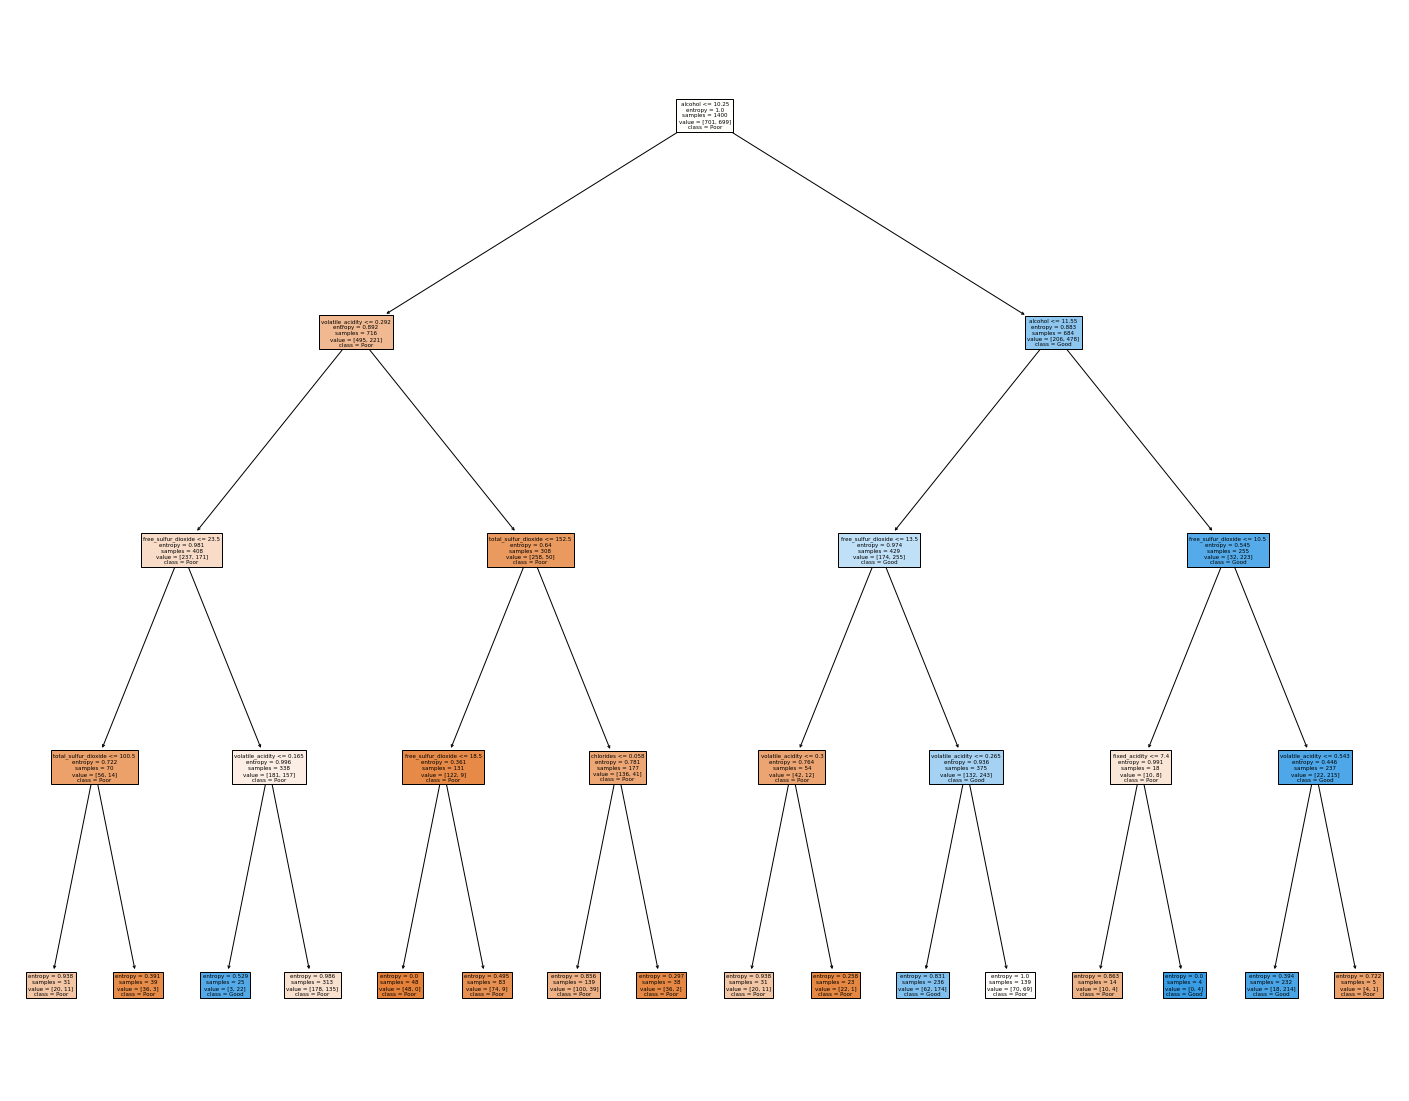

In [35]:
export_graphviz(dt,
                out_file="tree.dot",
                rounded=True,
                filled=True
               )
#save the decision_tree as png
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names=features,
                   class_names=wtype,
                   filled=True)
fig.savefig("decision_tree.png")

In [36]:
features[dt.feature_importances_.argmax()]

'alcohol'

**A:** wine that gets you drunk quicker is better ;)! You could test this actually by running pseudo experiments through the DT, but lets leave it at that.

#### 11. Fit a boosted decision tree classifier (1 Mark)


* Create a `sklearn.tree.GradientBoostingClassifier` and set the maximum tree depth to 4 and n_estimators to 20.
* Fit the boosted decision tree classifier
* Predict the response and pring the accuracy for the test and train datasets

In [37]:
# here we use the Gradient boosting classifier
max_depth    =  4
n_estimators = 100

bdt = GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_estimators)
bdt.fit(x_train, y_train)

GradientBoostingClassifier(max_depth=4)

In [38]:
y_pred = bdt.predict(x_train)
print("Accuracy Training:",metrics.accuracy_score(y_train, y_pred))
y_pred = bdt.predict(x_test)
print("Accuracy Testing:",metrics.accuracy_score(y_test, y_pred))

Accuracy Training: 0.9135714285714286
Accuracy Testing: 0.755


#### 12. Fit a Random forest decision tree classifier (1 Mark)

* Use the splitted dataset defined in exercise 10.
* Create a `sklearn.tree.RandomForestClassifier` and set the maximum tree depth to 4 and n_estimators to 20.
* Fit the random forest decision tree classifier
* Predict the response for the test dataset
* Print the accuracy
* Discuss the results of the accuracy for the 3 methods (DT, BDT, RF). How could you improve on the results?

In [39]:
# Fit a random forest classifier
rf = RandomForestClassifier(n_estimators=n_estimators, criterion = 'gini', max_depth=max_depth,random_state=1)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=4, random_state=1)

In [40]:
y_pred = rf.predict(x_train)
print("Accuracy Training:",metrics.accuracy_score(y_train, y_pred))
y_pred = rf.predict(x_test)
print("Accuracy Testing:",metrics.accuracy_score(y_test, y_pred))


Accuracy Training: 0.7778571428571428
Accuracy Testing: 0.74


**A**
- BDT performed better than all on training sample, but shows sign of overtraining
- RF performed marginally better than DT on testing sample, and has little overtraining
- Performace needs to be tuned by doing a hyperparameter optimisation